* Randomly shuffling / shifting the spikes of a raster leads to (dim 1) persistence diagrams with very few points, including persistence diagrams with no points at all.
* This occurs because some neurons have many spikes (say 150 total spikes throughout the experiment), while some neurons have only a few (say 30 total spikes throughout the experiment).
* When we randomly shuffle the spike times of each neuron, thereby preserving the total number of spikes in each neuron, the neurons with high number of spikes, let's call this n_high, becomes "equally close" to all other neurons. 
* This is like having a conal point on a cone. So we have a contractible space, and we are unlikely to observe nontrivial points on persistence diagrams.

In [1]:
using Pkg
Pkg.activate("../../env/.")
Pkg.instantiate()

  Activating project at `~/analogous_neural/env`


In [2]:
using Distributed

In [3]:
# print number of cores available
print(length(Sys.cpu_info()))

64

In [4]:
# add cores that I want to use
pids = addprocs(60);

In [4]:
include("../../src/analogous_bars.jl")
using .analogous_bars
using DelimitedFiles
using Measures
using Plots
@everywhere include("../../src/Eirene_var.jl")
@everywhere using .Eirene_var
@everywhere using Random
@everywhere using Distances
@everywhere using JLD2
@everywhere using PyCall
@everywhere using FileIO
@everywhere using Statistics
@everywhere using DelimitedFiles
@everywhere using Measures


WebIO._IJuliaInit()

In [5]:
@everywhere function shuffle_spike_trains(raster)
    n_cells, n_bins = size(raster)
    raster_shuffled = zeros((n_cells, n_bins))
    
    for cell in 1:n_cells
        # sample random number of shift
        raster_shuffled[cell, :] = shuffle(raster[cell,:])
    end
    return raster_shuffled
    
end

@everywhere function shuffle_raster(raster)
    n_neurons, n_bins, n_trials = size(raster)
    raster_shuffled = zeros((n_neurons, n_bins, n_trials))
    
    for cell in 1:n_neurons
        original_2d_raster = raster[cell, :, :]
        shuffled_2d_raster = original_2d_raster[shuffle(1:end),:]
        raster_shuffled[cell, :, :] = shuffled_2d_raster
    end
    return raster_shuffled
    
end

@everywhere function shift_raster(raster)
    n_neurons, n_bins, n_trials = size(raster)
    raster_shifted = zeros((n_neurons, n_bins, n_trials))
    
    for cell in 1:n_neurons
        original_2d_raster = raster[cell, :, :]
        for j = 1:20
            # sample random number of shift
            shift = rand(1:100, 1)[1]
            shifted = circshift(original_2d_raster[:,j], (shift))
            raster_shifted[cell, :, j] = shifted
        end
        #shifted_2d_raster = circshift(original_2d_raster, (shift, 0))
        #raster_shifted[cell, :, :] = shifted_2d_raster
    end
    return raster_shifted
    
end

@everywhere function compute_shuffled_persistence(V1_raster, AL_raster, V1_idx, AL_idx, output_dir, i)
    py"""
    import numpy as np
    from itertools import combinations
    # limited cross correlogram
    def limited_xcorr_neuron(raster1, neuron1, raster2, neuron2,limit_len, trial_num = None):
        # compute limited xcorr score among two neurons
        # note: the two neurons can be in the same region or be in different regions

        # raster_1: V1 raster or AL raster
        # neuron_1: index of V1 neuron
        # raster 2: V1 raster or AL raster
        # neuron_2: index of AL neuron
        # return a similarity score between two neurons

        n_neurons_1, n_bins_1, n_trials_1 = raster1.shape 
        n_neurons_2, n_bins_2, n_trials_2 = raster2.shape 

        n_bins = n_bins_1
        if n_bins_1 != n_bins_2:
            print("Error. Number of bins in two rasters do not match")

        if trial_num == None:
            spikes1 = list(raster1.sum(axis = 2)[neuron1])
            spikes2 = list(raster2.sum(axis = 2)[neuron2])
        else:
            spikes1 = list(raster1[:,:,trial_num][neuron1])
            spikes2 = list(raster2[:,:,trial_num][neuron2])

        x_corr = np.correlate(spikes1, spikes2, 'full')

        #normalize 
        norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))
        corr_norm = [x/norm_factor for x in x_corr]


        score = sum(corr_norm[n_bins-limit_len: n_bins+limit_len+1])
        return score
        
    def limited_xcorr(raster, neurons_idx, limit_len, trial_num = None):
        # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)

        # --- output ---
        # sim_score : array
        # distance : array
        # --------------
        n_neurons = len(neurons_idx)
        xcorr_array = np.zeros((n_neurons, n_neurons))

        for (i,j) in combinations(range(n_neurons),2):
            score = limited_xcorr_neuron(raster, neurons_idx[i], raster, neurons_idx[j], limit_len, trial_num = None)

            xcorr_array[i,j] = score
            xcorr_array[j,i] = score


            xcorr_array_scaled = xcorr_array/np.ceil(np.max(xcorr_array))
            distance = 1-xcorr_array_scaled
            np.fill_diagonal(distance, 0)    

        return xcorr_array, distance
    """
    
    # shuffle the rasters
    V1_raster_shuffled = shuffle_raster(V1_raster)
    AL_raster_shuffled = shuffle_raster(AL_raster)

    # compute distances
    V1_shuffled_xcorr, V1_shuffled_distance = py"limited_xcorr"(V1_raster_shuffled, V1_idx, 50)
    AL_shuffled_xcorr, AL_shuffled_distance = py"limited_xcorr"(AL_raster_shuffled, AL_idx, 50)
    
    # run persistence
    C_V1_shuffled = Eirene_var.eirene(V1_shuffled_distance)
    C_AL_shuffled = Eirene_var.eirene(AL_shuffled_distance)

    barcode_V1_shuffled = Eirene_var.barcode(C_V1_shuffled, dim = 1)
    barcode_AL_shuffled = Eirene_var.barcode(C_AL_shuffled, dim = 1)

    # save
    save(output_dir * string(i) * ".jld2",  "V1_shuffled_barcode", barcode_V1_shuffled,
                                            "AL_shuffled_barcode", barcode_AL_shuffled)
    
end


In [25]:
py"""
import numpy as np
from itertools import combinations

# limited cross correlogram
def limited_xcorr_neuron(raster1, neuron1, raster2, neuron2, limit_len, trial_num=None):
    # compute limited xcorr score among two neurons
    # note: the two neurons can be in the same region or be in different regions

    # raster_1: V1 raster or AL raster
    # neuron_1: index of V1 neuron
    # raster2: V1 raster or AL raster
    # neuron2: index of AL neuron
    # return a similarity score between two neurons

    n_neurons_1, n_bins_1, n_trials_1 = raster1.shape
    n_neurons_2, n_bins_2, n_trials_2 = raster2.shape

    n_bins = n_bins_1
    if n_bins_1 != n_bins_2:
        print("Error. Number of bins in two rasters do not match")

    if trial_num is None:
        spikes1 = list(raster1.sum(axis=2)[neuron1])
        spikes2 = list(raster2.sum(axis=2)[neuron2])
    else:
        spikes1 = list(raster1[:, :, trial_num][neuron1])
        spikes2 = list(raster2[:, :, trial_num][neuron2])

    x_corr = np.correlate(spikes1, spikes2, 'full')

    # normalize
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))

    corr_norm = [x / norm_factor for x in x_corr]

    score = sum(corr_norm[n_bins - limit_len: n_bins + limit_len + 1])
    return score

def limited_xcorr(raster, neurons_idx, limit_len, trial_num=None):
    # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)

    # --- output ---
    # sim_score : array
    # distance : array
    # --------------
    n_neurons = len(neurons_idx)
    xcorr_array = np.zeros((n_neurons, n_neurons))

    for (i, j) in combinations(range(n_neurons), 2):
        print(i,j)
        score = limited_xcorr_neuron(raster, neurons_idx[i], raster, neurons_idx[j], limit_len, trial_num)

        xcorr_array[i, j] = score
        xcorr_array[j, i] = score

    xcorr_array_scaled = xcorr_array / np.ceil(np.max(xcorr_array))
    distance = 1 - xcorr_array_scaled
    np.fill_diagonal(distance, 0)

    return xcorr_array, distance


def limited_xcorr_neuron_spiketrain(raster1, neuron1, raster2, neuron2, limit_len):
    # compute limited xcorr score among two neurons
    # note: the two neurons can be in the same region or be in different regions

    # raster_1: V1 raster or AL raster
    # neuron_1: index of V1 neuron
    # raster2: V1 raster or AL raster
    # neuron2: index of AL neuron
    # return a similarity score between two neurons

    n_neurons_1, n_bins_1 = raster1.shape
    n_neurons_2, n_bins_2 = raster2.shape

    n_bins = n_bins_1
    if n_bins_1 != n_bins_2:
        print("Error. Number of bins in two rasters do not match")

    spikes1 = raster1[neuron1,:]
    spikes2 = raster2[neuron2,:]

    x_corr = np.correlate(spikes1, spikes2, 'full')

    # normalize
    norm_factor = np.sqrt(np.dot(spikes1, spikes1) * np.dot(spikes2, spikes2))

    corr_norm = [x / norm_factor for x in x_corr]

    score = sum(corr_norm[n_bins - limit_len: n_bins + limit_len + 1])
    return score

def limited_xcorr_aggregate_raster(raster, limit_len, scale_factor = None):
    # compute limited xcorr similarity and distance for neurons in one region (V1 or AL)

    # --- output ---
    # sim_score : array
    # distance : array
    # --------------
    n_neurons, n_bins = raster.shape
    xcorr_array = np.zeros((n_neurons, n_neurons))

    for (i, j) in combinations(range(n_neurons), 2):
        score = limited_xcorr_neuron_spiketrain(raster, i, raster, j, limit_len)

        xcorr_array[i, j] = score
        xcorr_array[j, i] = score

    if scale_factor == None:
        scale_factor = np.ceil(np.max(xcorr_array))

    xcorr_array_scaled = xcorr_array / scale_factor
    distance = 1 - xcorr_array_scaled
    np.fill_diagonal(distance, 0)

    return xcorr_array, distance

    """


    function shuffle_2d_raster(raster)
        n_neurons, n_bins, n_trials = size(raster)
        raster_shuffled = zeros((n_neurons, n_bins, n_trials))
        
        for cell in 1:n_neurons
            original_2d_raster = raster[cell, :, :]
            shuffled_2d_raster = original_2d_raster[shuffle(1:end),:]
            raster_shuffled[cell, :, :] = shuffled_2d_raster
        end
        return raster_shuffled
        
    end
    
    function shuffle_1d_raster(raster_1d)
        n_neurons, n_bins = size(raster_1d)
        raster_1d_shuffled = zeros((n_neurons, n_bins))
        for cell in 1:n_neurons
            original_1d_raster = raster_1d[cell, :]
            shuffled_1d_raster = original_1d_raster[shuffle(1:end), :]
            raster_1d_shuffled[cell,:] = shuffled_1d_raster
        end
    
        return raster_1d_shuffled
    
    end

shuffle_1d_raster (generic function with 1 method)

Load data

In [6]:
# load pkl data
py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

load_pickle = py"load_pickle"

PyObject <function load_pickle at 0x7fdf73a27f60>

In [7]:
# load raster
AL_raster = load_pickle("data/AL_st_raster.pkl")["stimulus_1"]
V1_raster = load_pickle("data/V1_st_raster.pkl")["stimulus_1"];

# load indices (Python indices)
V1_idx = readdlm("data/V1_neurons_idx.txt", '\t', Int, '\n')
AL_idx = readdlm("data/AL_neurons_idx.txt", '\t', Int, '\n');

V1_idx_python = vcat(V1_idx...)
AL_idx_python = vcat(AL_idx...);
V1_idx_julia = [i+1 for i in V1_idx_python]
AL_idx_julia = [i+1 for i in AL_idx_python]

V1_raster_small = V1_raster[V1_idx_julia,:,:]
AL_raster_small = AL_raster[AL_idx_julia,:,:];

# spike trains (aggregate raster)
V1_aggregate_small = sum(V1_raster_small, dims = 3)[:,:,1];
AL_aggregate_small = sum(AL_raster_small, dims = 3)[:,:,1];

In [8]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

# Illustration of shuffling and shifting

(a) Shuffle the aggreate spike trains. 

In [19]:
V1_aggregate_shuffled = shuffle_1d_raster(V1_aggregate_small);

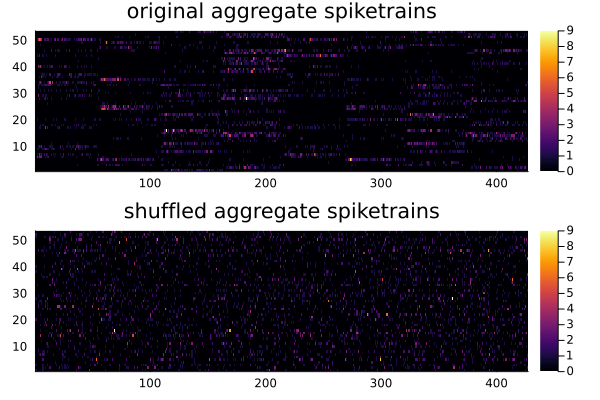

In [10]:
p1 = heatmap(V1_aggregate_small, title = "original aggregate spiketrains")
p2 = heatmap(V1_aggregate_shuffled, title = "shuffled aggregate spiketrains")
plot(p1, p2, layout = (2,1))

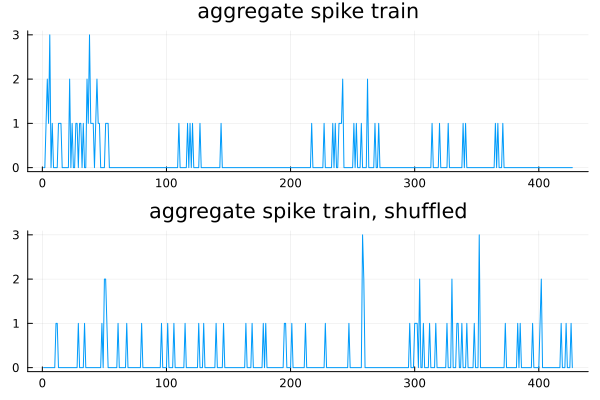

In [11]:
neuron = 10
p1 = plot(V1_aggregate_small[neuron,:], label = "", title = "aggregate spike train")
p2 = plot(V1_aggregate_shuffled[neuron,:], label = "", title = "aggregate spike train, shuffled")
plot(p1, p2, layout = (2,1))


In [26]:
_, shuffled_distance = py"limited_xcorr_aggregate_raster"(V1_aggregate_shuffled, 50, scale_factor = 33)
C_V1_shuffled = Eirene_var.eirene(shuffled_distance)
barcode_V1_shuffled = Eirene_var.barcode(C_V1_shuffled, dim = 1)

0×2 Matrix{Float64}

The barcode above will often be empty.

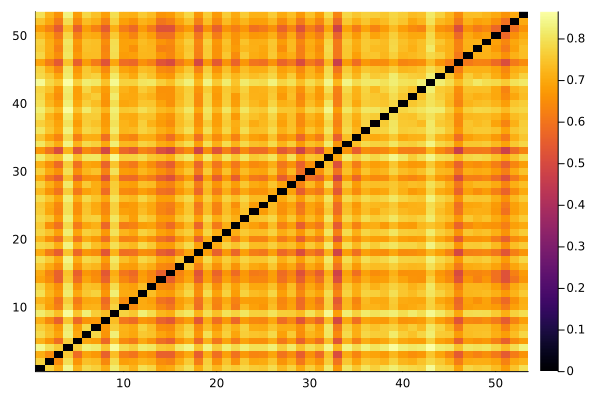

In [13]:
heatmap(shuffled_distance)

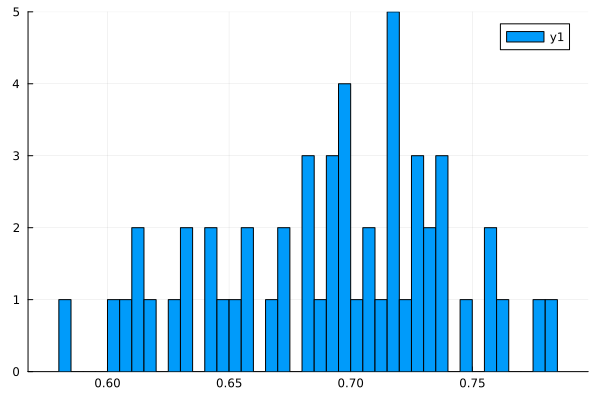

In [14]:
mean_dissimilarity = vec(mean(shuffled_distance, dims = 1));
histogram(mean_dissimilarity, bins = 50)

In [28]:
shuffled_distance

53×53 Matrix{Float64}:
 0.0       0.771267  0.708415  0.844216  …  0.67832   0.746279  0.796145
 0.771267  0.0       0.648785  0.79658      0.628894  0.699231  0.720218
 0.708415  0.648785  0.0       0.757572     0.545148  0.616805  0.659239
 0.844216  0.79658   0.757572  0.0          0.734023  0.791259  0.832485
 0.717896  0.663615  0.5857    0.76633      0.556676  0.644612  0.680205
 0.7863    0.742164  0.691642  0.827149  …  0.680651  0.734394  0.779737
 0.765748  0.731483  0.669865  0.817385     0.628886  0.711394  0.741803
 0.710347  0.641997  0.558688  0.750312     0.546632  0.632566  0.681601
 0.819027  0.7867    0.737068  0.856919     0.711016  0.770602  0.791968
 0.75827   0.682368  0.621813  0.789424     0.616841  0.683624  0.716835
 0.718265  0.69216   0.602635  0.763004  …  0.577291  0.657511  0.710812
 0.79546   0.720462  0.671582  0.817751     0.67284   0.718372  0.757558
 0.775431  0.70839   0.653319  0.806057     0.614041  0.700972  0.733991
 ⋮                          



Shuffling individual trials and then aggregating has similar results.

In [35]:
using MultivariateStats

In [36]:
M = fit(MDS, shuffled_distance; maxoutdim=2, distances=true)

Classical MDS(indim = NaN, outdim = 2)

In [37]:
Y = predict(M)

2×53 Matrix{Float64}:
  0.192065   -0.0886909   -0.00796882  …   0.1111     0.0889047  0.0405942
 -0.0114539  -0.00255884  -0.0315459      -0.078928  -0.0765817  0.0594209

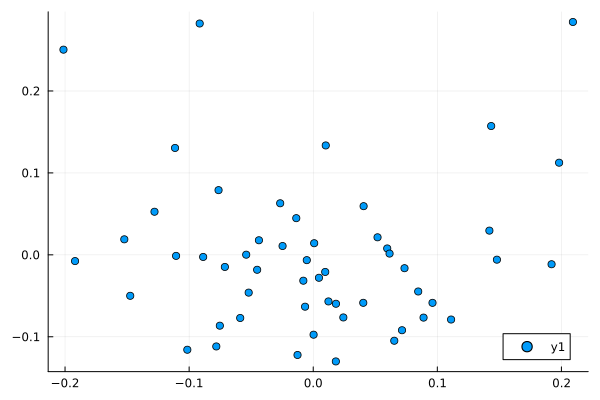

In [39]:
scatter(Y[1,:], Y[2,:])

(b) Shifting spike trains

In [24]:
function shift_raster(raster; shift_limit = 100)
    n_neurons, n_bins, n_trials = size(raster)
    raster_shifted = zeros((n_neurons, n_bins, n_trials))
    
    for cell in 1:n_neurons
        original_2d_raster = raster[cell, :, :]
        for j = 1:20
            # sample random number of shift
            shift = rand(-shift_limit:shift_limit)
            shifted = circshift(original_2d_raster[:,j], (shift))
            raster_shifted[cell, :, j] = shifted
        end
    end
    return raster_shifted
    
end

shift_raster (generic function with 1 method)

In [25]:
V1_raster_shifted = shift_raster(V1_raster, shift_limit = 80);

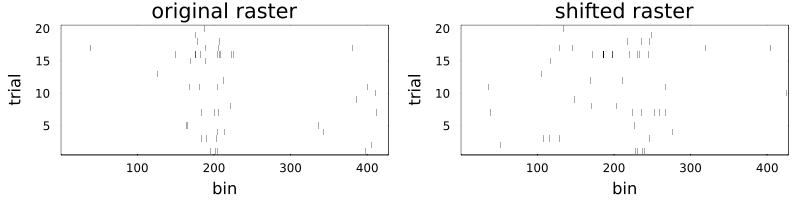

In [26]:
neuron =V1_idx_julia[42]
p1 = heatmap(transpose(V1_raster[neuron, :, :]), colorbar = :false, size = (800, 200), c = :binary, frame = :box,
        xlabel = "bin", ylabel ="trial", title = "original raster", left_margin = 5mm, bottom_margin = 5mm, top_margin = 2mm)

p2 = heatmap(transpose(V1_raster_shifted[neuron, :, :]), colorbar = :false, size = (800, 200), c = :binary, frame = :box,
        xlabel = "bin", ylabel ="trial", title = "shifted raster", left_margin = 5mm, bottom_margin = 2mm)
p = plot(p1, p2)

plot(p)

In [27]:
V1_shifted_aggregate = sum(V1_raster_shifted[V1_idx_julia,:,:], dims = 3)[:,:,1];

In [28]:
# compute distances
V1_shifted_xcorr, V1_shifted_distance = py"limited_xcorr_aggregate_raster"(V1_shifted_aggregate, 50; scale_factor = 33)

C_V1_shifted = Eirene_var.eirene(V1_shifted_distance)
barcode_V1_shuffled = Eirene_var.barcode(C_V1_shifted, dim = 1)

3×2 Matrix{Float64}:
 0.314504  0.331232
 0.279829  0.308753
 0.31186   0.4006

Here, as we increase the allowed shift parameter `shift_limit` to increase, the persistence diagram becomes more and more empty. 

# Compute persistence diagrams from shuffled data  * 1000

* We computed the persistence diagrams from randomly shuffled spike trains 1,000 times.
* Output saved in `PD_significance_experiments/shuffled_PD`
* Most persistence diagrams were empty

In [9]:
output_dir = "PD_significance_experiments/shuffled_PD/shuffled_PD"

"PD_significance_experiments/shuffled_PD/shuffled_PD"

In [14]:
# shuffle the rasters
V1_raster_shuffled = shuffle_raster(V1_raster)
AL_raster_shuffled = shuffle_raster(AL_raster);


In [ ]:
V1_aggregate_shuffled = 

In [ ]:
shuffled_distance = py"limited_xcorr_aggregate_raster"(V1_aggregate_shuffled, 50, scale_factor = 33)

In [17]:
# compute distances
V1_shuffled_xcorr, V1_shuffled_distance = py"limited_xcorr"(V1_raster_shuffled, V1_idx, 50)
#AL_shuffled_xcorr, AL_shuffled_distance = py"limited_xcorr"(AL_raster_shuffled, AL_idx, 50)


0 1


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/hyoon/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('object too deep for desired array')
  File "/home/hyoon/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 51, in limited_xcorr
    For example, `pyeval("x + y", x=1, y=2)` returns 3.
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hyoon/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 29, in limited_xcorr_neuron
    # internal function evaluate a python string, returning PyObject, given
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hyoon/anaconda3/lib/python3.11/site-packages/numpy/core/numeric.py", line 731, in correlate
    return multiarray.correlate2(a, v, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [10]:
compute_shuffled_persistence(V1_raster, AL_raster, V1_idx, AL_idx, output_dir, 1001)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/hyoon/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('object too deep for desired array')
  File "/home/hyoon/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 49, in limited_xcorr
    This evaluates `s` as a Python string and returns the result converted to `rtype` (which defaults to `PyAny`). The remaining arguments are keywords that define local variables to be used in the expression.
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hyoon/.julia/packages/PyCall/1gn3u/src/pyeval.jl", line 28, in limited_xcorr_neuron
  File "/home/hyoon/anaconda3/lib/python3.11/site-packages/numpy/core/numeric.py", line 731, in correlate
    return multiarray.correlate2(a, v, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
@distributed for i=1001:5000
    compute_shuffled_persistence(V1_raster, AL_raster, V1_idx, AL_idx, output_dir, i)
end

In [30]:
V1_shuffled_persistence = []
AL_shuffled_persistence = []
output_dir = "PD_significance_experiments/shuffled_PD/shuffled_PD"
for i = 1:1000
    # open julia files
    V1_shuffled = FileIO.load(output_dir * string(i) * ".jld2")["V1_shuffled_barcode"]
    AL_shuffled = FileIO.load(output_dir * string(i) * ".jld2")["AL_shuffled_barcode"]
    
    V1_shuffled_persistence = vcat(V1_shuffled_persistence, V1_shuffled[:,2] - V1_shuffled[:,1])
    AL_shuffled_persistence = vcat(AL_shuffled_persistence, AL_shuffled[:,2] - AL_shuffled[:,1])
end

In [31]:
AL_shuffled_persistence

1-element Vector{Any}:
 0.002486882017465497

In [32]:
AL_shuffled_persistence

1-element Vector{Any}:
 0.002486882017465497

In [33]:
V1_shuffled_persistence

75-element Vector{Any}:
 0.0021069608317523247
 0.009458765353686394
 0.0009388322463803611
 0.01772641357915139
 0.01797651434058034
 0.007922570543576257
 0.0001813259644645182
 0.0010219098781274472
 0.0009395870082509195
 0.004460443564383576
 0.0019933184041713847
 0.01815809904296517
 0.0010696887354502138
 ⋮
 0.0037302560393128736
 0.0017494743588905015
 0.0014819660438093463
 0.007172579607311658
 0.0023956327952657785
 0.009611735947236522
 0.00011962377919061407
 0.001511097204998979
 0.002422765443268471
 0.0017490882089149506
 0.004477030900344903
 0.005976791269980519

In [34]:
maximum(V1_shuffled_persistence)

0.01815809904296517

# Shifted aggregate spike trains

In [9]:
function shift_aggregate_raster(raster)
    n_neurons, n_bins = size(raster)
    raster_shifted = zeros((n_neurons, n_bins))
    
    for cell in 1:n_neurons
        # sample random number of shift
        shift = rand(1:n_bins, 1)[1]
        original_spiketrain = raster[cell, :]
        shifted_spiketrain = circshift(original_spiketrain, shift)
        raster_shifted[cell, :] = shifted_spiketrain
    end
    return raster_shifted
    
end

shift_aggregate_raster (generic function with 1 method)

In [10]:
V1_raster_shifted = shift_aggregate_raster(V1_aggregate_small);


In [28]:
AL_raster_shifted = shift_aggregate_raster(AL_aggregate_small);

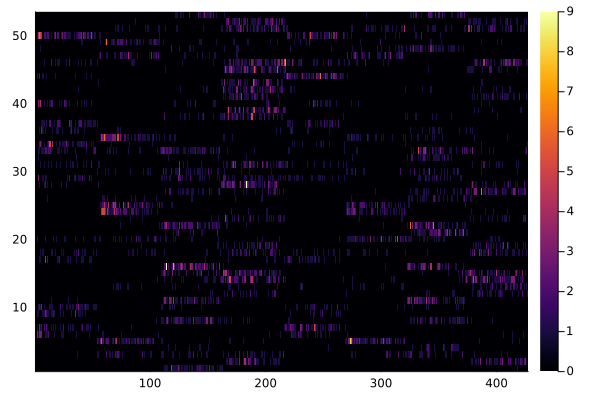

In [12]:
heatmap(V1_aggregate_small)

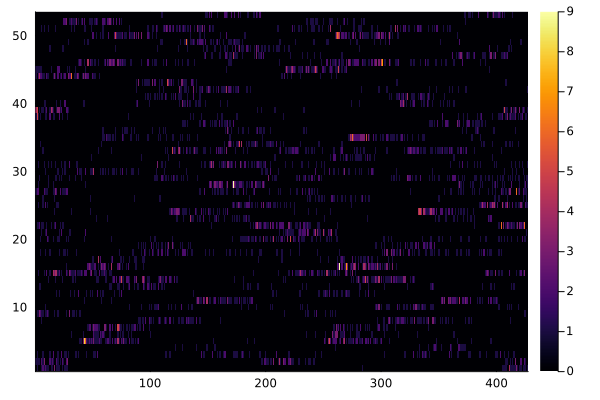

In [13]:
heatmap(V1_raster_shifted)

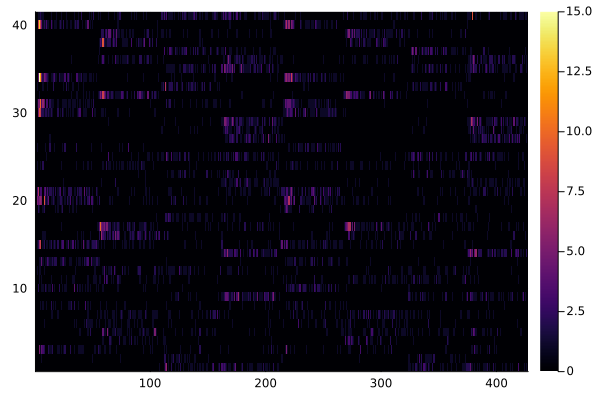

In [29]:
heatmap(AL_aggregate_small)

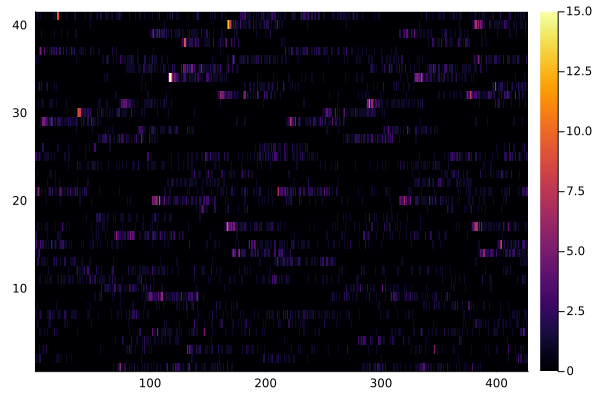

In [30]:
heatmap(AL_raster_shifted)

In [31]:
# compute distances
_, V1_shifted_distance = py"limited_xcorr_aggregate_raster"(V1_raster_shifted, 50; scale_factor = 33)
_, AL_shifted_distance = py"limited_xcorr_aggregate_raster"(AL_raster_shifted, 50; scale_factor = 33)

([0.0 3.7456774353715883 … 9.366485570785843 15.185300857654598; 3.7456774353715883 0.0 … 11.207361763686599 15.245374044663722; … ; 9.366485570785843 11.207361763686599 … 0.0 15.013613978567363; 15.185300857654598 15.245374044663722 … 15.013613978567363 0.0], [0.0 0.8864946231705579 … 0.7161671039155806 0.5398393679498606; 0.8864946231705579 0.0 … 0.6603829768579819 0.5380189683435236; … ; 0.7161671039155806 0.6603829768579819 … 0.0 0.5450420006494738; 0.5398393679498606 0.5380189683435236 … 0.5450420006494738 0.0])

In [32]:
C_V1 = eirene(V1_shifted_distance, maxdim = 1)
barcode_V1 = barcode(C_V1, dim = 1)
C_AL = eirene(AL_shifted_distance, maxdim = 1)
barcode_AL = barcode(C_AL, dim = 1)

4×2 Matrix{Float64}:
 0.336977  0.346869
 0.312596  0.317966
 0.471159  0.472225
 0.392421  0.531597

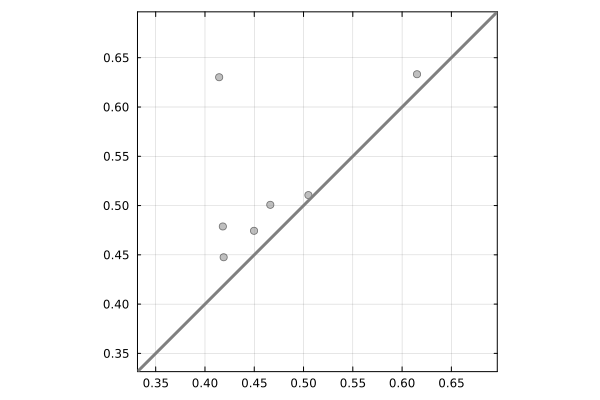

In [33]:
plot_PD(barcode_V1)

In [34]:
select_persistent_intervals_IQR(barcode_V1)

([7], 0.12618489385172427)

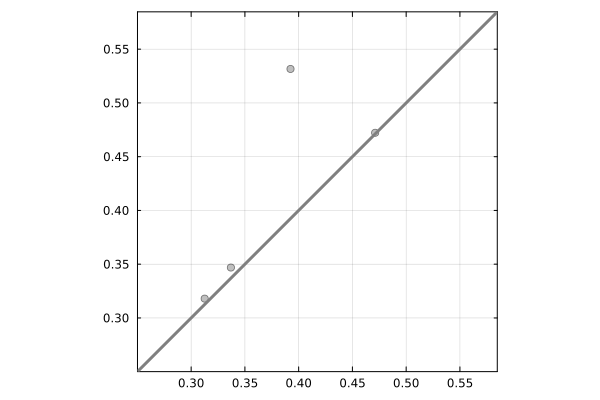

In [35]:
plot_PD(barcode_AL)

In [36]:

save("PD_significance_experiments/aggregate_shifted_rasters.jld2",  
"V1_raster_shifted", V1_raster_shifted,
"AL_raster_shifted", AL_raster_shifted,
"V1_barcode", barcode_V1,
"AL_barcode", barcode_AL,
"V1_distance", V1_shifted_distance,
"AL_distance", AL_shifted_distance
)


writedlm( "PD_significance_experiments/aggregate_shifted_V1_distance.csv",  V1_shifted_distance, ',')

writedlm( "PD_significance_experiments/aggregate_shifted_AL_distance.csv",  AL_shifted_distance, ',')

In [70]:
output_dir = "PD_significance_experiments/shuffled_shifted_persistence/"
i = 7
# open julia files
V1_shifted = FileIO.load(output_dir * string(i) * ".jld2")["V1_shifted_barcode"]
AL_shifted = FileIO.load(output_dir * string(i) * ".jld2")["AL_shifted_barcode"]


5×2 Matrix{Float64}:
 0.273927  0.294635
 0.286167  0.300357
 0.223348  0.230275
 0.352224  0.362389
 0.228373  0.374808

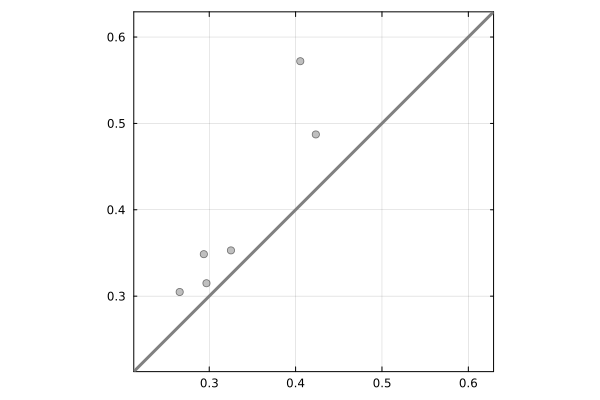

In [71]:
plot_PD(V1_shifted)

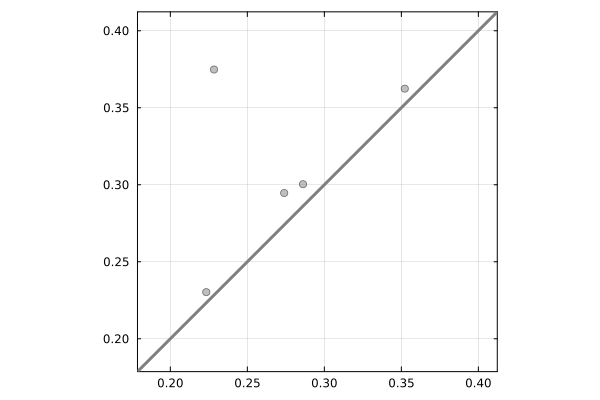

In [72]:
plot_PD(AL_shifted)